# Import libraries and modules

In [1]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1.0  # 1e-3
integrator_keywords['atol'] = 1.0  # 1e-4
integrator_keywords['max_step'] = 0.1
integrator_keywords['h_factor'] = 1

system_size = 50
n_samples_train = 2000
n_samples_test = 5000

poly_order = 2
threshold = 0
dt = 1

Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

In [2]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

# Load data

In [3]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# # n_samples_train random indices
# indices = np.random.choice(len(t_values), n_samples_train, replace=False)
# indices = np.sort(indices)
# Linearly spaced indices
indices = np.linspace(0, len(t_values)-1, n_samples_train, dtype=int)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

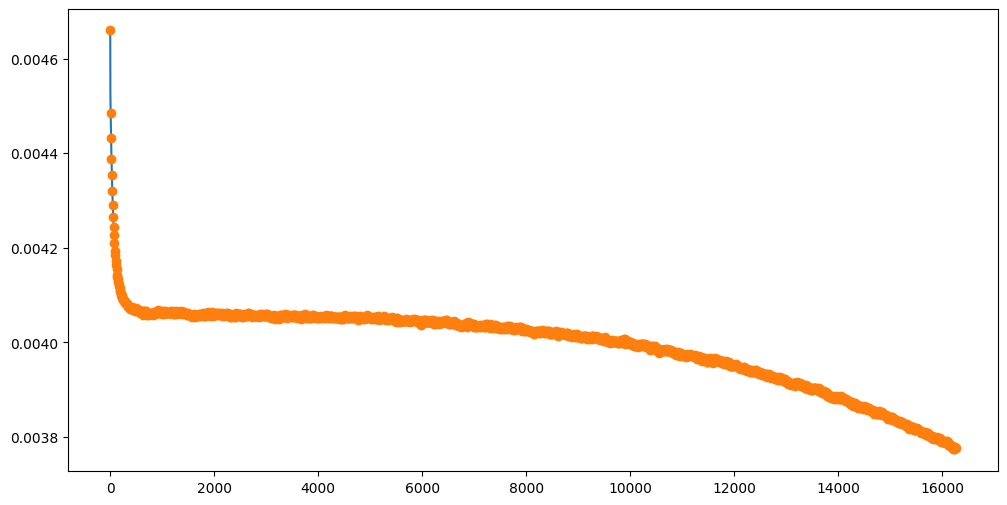

In [4]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Build and fit the model

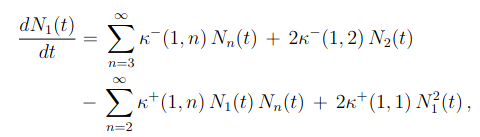

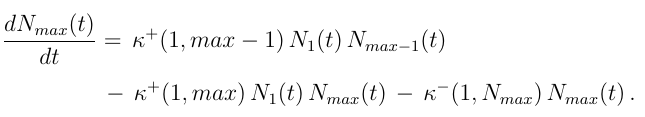

In [5]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(N_clusters_train, {"ax_sample": 0, "ax_coord": 1})])
features_names = library.get_feature_names()
n_features = library.n_output_features_
print(f"Features ({n_features}):", features_names)

Features (1326): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x0 x20', 'x0 x21', 'x0 x22', 'x0 x23', 'x0 x24', 'x0 x25', 'x0 x26', 'x0 x27', 'x0 x28', 'x0 x29', 'x0 x30', 'x0 x31', 'x0 x32', 'x0 x33', 'x0 x34', 'x0 x35', 'x0 x36', 'x0 x37', 'x0 x38', 'x0 x39', 'x0 x40', 'x0 x41', 'x0 x42', 'x0 x43', 'x0 x44', 'x0 x45', 'x0 x46', 'x0 x47', 'x0 x48', 'x0 x49', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16'

In [6]:
# Set constraints
n_targets = N_clusters_train.shape[1]

constraint_rhs = np.array([0, 28])# One row per constraint, one column per coefficient

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

print(f"constraint_rhs.shape: {constraint_rhs.shape}")
print(f"constraint_lhs.shape: {constraint_lhs.shape}")

constraint_rhs.shape: (2,)
constraint_lhs.shape: (2, 66300)


In [7]:
constraint_rhs, constraint_lhs

(array([ 0, 28]),
 array([[0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [8]:
print(f"Features ({n_features}):", features_names)

# Set constraints
n_targets = N_clusters_train.shape[1]


### Set constraints for the first cluster size 
## 1 -Quadratic terms (^2 or 2 x's') to be zero except for the terms with x0

# Find the indices of quadratic terms in the features_names list
# quadratic_idx_pure = [i for i, feature_name in enumerate(features_names) if '^2' in feature_name and 'x0^2' not in feature_name]
quadratic_idx_first = [i for i, feature_name in enumerate(features_names) if ('^2' in feature_name or feature_name.count('x') == 2) and 'x0' not in feature_name]
n_quadratic_first = len(quadratic_idx_first)

# Initialize constraint_rhs
constraint_rhs = np.zeros(n_quadratic_first)

# Initialize constraint_lhs
constraint_lhs = np.zeros((n_quadratic_first, n_targets * n_features))

# Set the coefficient of each quadratic term (excluding 'x0^2') to zero
for i, idx in enumerate(quadratic_idx_first):
    # Exclude 'x0^2'
    if 'x0^2' != features_names[idx]:
        constraint_lhs[i, idx] = 1

print(f"quadratic_idx_pure (excluding 'x0^2'): {quadratic_idx_first}")
print(f"constraint_rhs.shape: {constraint_rhs.shape}")
print(f"constraint_lhs.shape: {constraint_lhs.shape}")

## 2- Coeff of x0 is zero
constraint_rhs = np.append(constraint_rhs, 0)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
# Get the index of x0
x0_idx = features_names.index('x0')
constraint_lhs[-1, x0_idx] = 1

last_row = n_quadratic_first + 1

### Add constraints for the last cluster
## 1 - All linear terms to be zero except for xN
linear_indices = [i for i, feature_name in enumerate(features_names) if feature_name.count('x') == 1 \
                and '^' not in feature_name \
                and f'x{n_targets - 1}' not in feature_name]
n_linear = len(linear_indices)

# Add more columns to constraint_rhs
constraint_rhs = np.append(constraint_rhs, np.zeros(n_linear))

# Add more rows to constraint_lhs
constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_linear, n_targets * n_features))))

# Set the coefficient of each linear term (excluding 'xN') to zero
for i, idx in enumerate(linear_indices):
    # Exclude 'xN'
    print(f'x{n_targets - 1}', features_names[idx])
    # if f'x{n_targets - 1}' != features_names[idx]:
    constraint_lhs[i + last_row, (n_targets - 1) * n_features + idx] = 1

print(f"linear_indices: {linear_indices}")
print(f"constraint_rhs.shape: {constraint_rhs.shape}")
print(f"constraint_lhs.shape: {constraint_lhs.shape}")

last_row = last_row + n_linear

## 2 - All quadratic terms to be zero except for x0 xN and x0 xN-1 
quadratic_idx_last = [i for i, feature_name in enumerate(features_names) if (feature_name.count('x') == 2 \
                     and f'x0 x{n_targets - 1}' not in feature_name \
                     and f'x0 x{n_targets - 2}' not in feature_name) or '^2' in feature_name]
n_quadratic_last = len(quadratic_idx_last)
  
# Add more columns to constraint_rhs
constraint_rhs = np.append(constraint_rhs, np.zeros(n_quadratic_last))

# Add more rows to constraint_lhs
constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_quadratic_last, n_targets * n_features))))

# Set the coefficient of each quadratic term (excluding 'x0 xN' and 'x0 xN-1') to zero
for i, idx in enumerate(quadratic_idx_last):
    # Exclude 'x0 xN' and 'x0 xN-1'
    constraint_lhs[i + last_row, (n_targets - 1) * n_features + idx] = 1

# print(f"quadratic_idx_mix: {quadratic_idx_last}")
# print(f"constraint_rhs.shape: {constraint_rhs.shape}")
# print(f"constraint_lhs.shape: {constraint_lhs.shape}")





Features (1326): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x0 x20', 'x0 x21', 'x0 x22', 'x0 x23', 'x0 x24', 'x0 x25', 'x0 x26', 'x0 x27', 'x0 x28', 'x0 x29', 'x0 x30', 'x0 x31', 'x0 x32', 'x0 x33', 'x0 x34', 'x0 x35', 'x0 x36', 'x0 x37', 'x0 x38', 'x0 x39', 'x0 x40', 'x0 x41', 'x0 x42', 'x0 x43', 'x0 x44', 'x0 x45', 'x0 x46', 'x0 x47', 'x0 x48', 'x0 x49', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16'

In [9]:
smoothed_fd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})

differentiation_method = smoothed_fd

# # optimizer = ps.STLSQ(threshold=threshold)
optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs
)

# # Define the constraints for the first equation
# optimizer_first = ps.ConstrainedSR3(
#     constraint_rhs=constraint_rhs_first, constraint_lhs=constraint_lhs_first
# )

# # Define the constraints for the last equation
# optimizer_last = ps.ConstrainedSR3(
#     constraint_rhs=constraint_rhs_last, constraint_lhs=constraint_lhs_last
# )

feature_library = ps.PolynomialLibrary(degree=poly_order)

# Fit the model
model = ps.SINDy( 
    differentiation_method=differentiation_method,
    optimizer=optimizer,
    # optimizer=[optimizer_first, optimizer_last],  # Pass a list of optimizers
    feature_library=feature_library,
)
model.fit(N_clusters_train, t=dt)

# Print the model
model.print()

(x0)' = 1.551 x1 + -33.885 x2 + 45.478 x3 + -16.116 x4 + -124.667 x5 + -15.440 x6 + -72.514 x7 + 44.028 x8 + 66.648 x9 + -57.999 x10 + 105.698 x11 + -238.292 x12 + -55.595 x13 + -85.512 x14 + -26.684 x15 + -103.270 x16 + -36.054 x17 + 11.162 x18 + -19.368 x19 + 0.652 x20 + 10.430 x21 + -30.485 x22 + 13.171 x23 + -18.860 x24 + -1.129 x25 + 10.514 x26 + 15.484 x27 + 31.516 x28 + 7.023 x29 + 13.065 x30 + 2.688 x31 + -19.035 x32 + 10.118 x33 + -10.874 x34 + 2.205 x35 + -14.279 x36 + 12.584 x37 + -26.774 x38 + 9.208 x39 + -12.644 x40 + 3.546 x41 + 2.165 x42 + -7.510 x43 + 11.242 x44 + 19.774 x45 + -0.486 x46 + 1.890 x47 + -8.024 x48 + -3.152 x49 + -77.703 x0^2 + -1743.608 x0 x1 + 20664.166 x0 x2 + -41756.441 x0 x3 + -3790.288 x0 x4 + 30112.324 x0 x5 + 2648.283 x0 x6 + 17615.246 x0 x7 + -11074.918 x0 x8 + -17400.373 x0 x9 + 14157.210 x0 x10 + -26960.986 x0 x11 + 60050.814 x0 x12 + 12905.725 x0 x13 + 19481.544 x0 x14 + 5059.457 x0 x15 + 27009.092 x0 x16 + 9322.128 x0 x17 + -4421.914 x0 x18 + 

In [10]:
# N_clusters_train
# Find min value gretaer than 0
min_val = np.min(N_clusters_train[N_clusters_train > 0])
min_val

2.4995300883433915e-09

In [11]:
# model.print_simpy()

In [12]:
# # Print the model
# # model.print()

# save_folder = 'ck_experiments'
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)
    
# model.save(save_folder, precision=4)

In [13]:
N_clusters.shape, N_clusters[0].shape

((16257, 50), (50,))

In [17]:
# # integrator_keywords['method'] = 'RK23'
# # integrator_keywords['rtol'] = 1e-4
# # integrator_keywords['atol'] = 1e-6
# integrator_keywords['method'] = 'BDF'
# integrator_keywords['rtol'] = 1e-3
# integrator_keywords['atol'] = 1e-10
# n_samples_test = 1000
# n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], integrator_kws=integrator_keywords)

integrator_keywords['method'] = 'Euler'   # 'RK2'   #'RK4' 
integrator_keywords['h_factor'] = 500

n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], 
                              integrator='fixed_step', integrator_kws=integrator_keywords)

fixed_step {'method': 'Euler', 'rtol': 1.0, 'atol': 1.0, 'max_step': 0.1, 'h_factor': 500}
t: 27.0

In [ ]:
n_sim.shape, t_sim.shape

((5000, 50), (5000,))

/tmp/ipykernel_3432221/386159276.py:11: RuntimeWarning: divide by zero encountered in log
  t_values_log = np.log(t_values)
/tmp/ipykernel_3432221/386159276.py:12: RuntimeWarning: divide by zero encountered in log
  t_sim_log = np.log(t_sim)


Cluster size 100 is larger than the system size 50


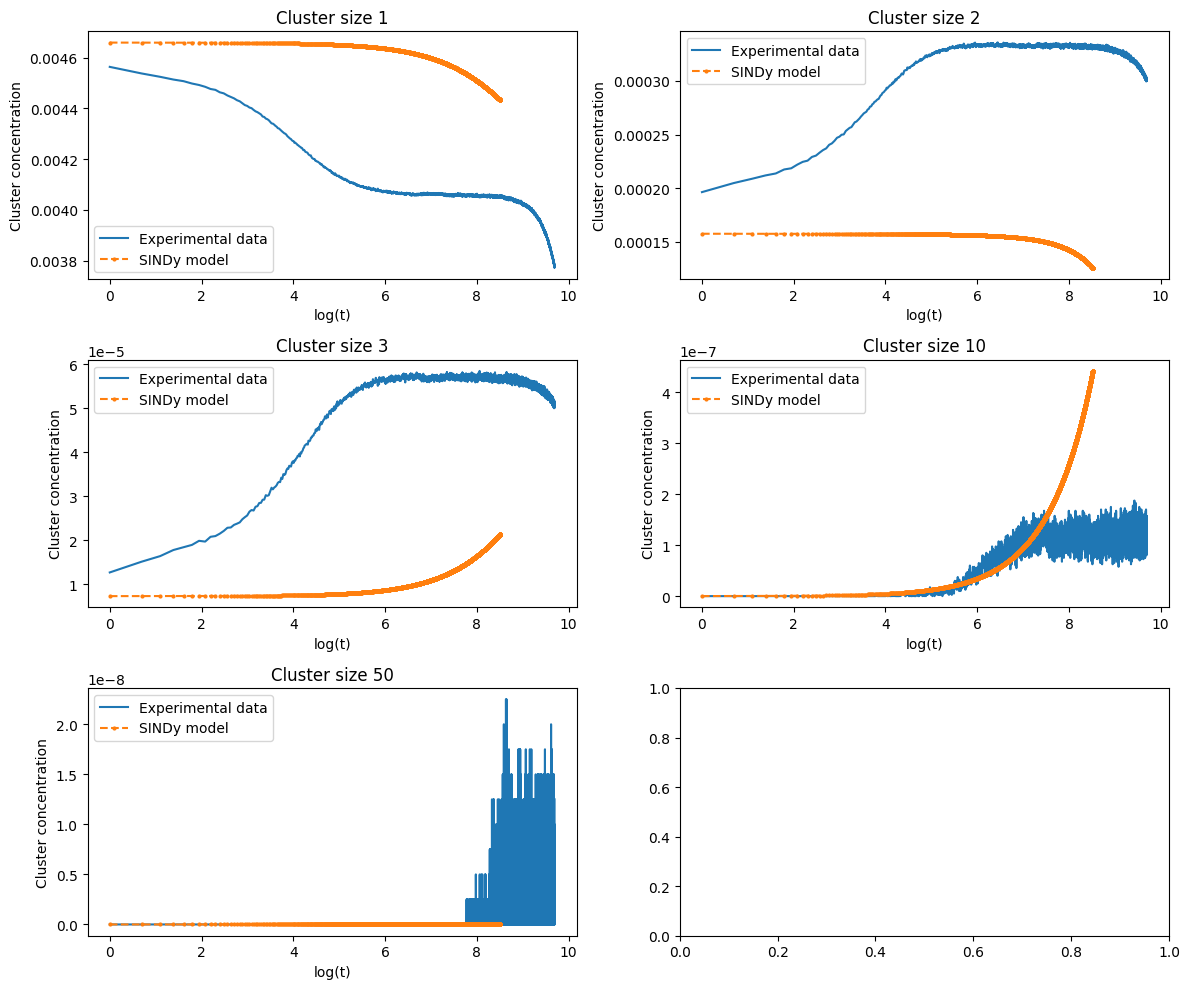

In [ ]:
# List of IDs to plot
ids_to_plot = [1, 2, 3, 10, 50, 100]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Log the time values
t_values_log = np.log(t_values)
t_sim_log = np.log(t_sim)

for i, n_to_plot in enumerate(ids_to_plot):
    
    if n_to_plot > system_size:
        print(f"Cluster size {n_to_plot} is larger than the system size {system_size}")
        continue
    # Plot the data
    axs[i].plot(t_values_log, N_clusters[:, n_to_plot-1], label=f'Experimental data')
    axs[i].plot(t_sim_log, n_sim[:, n_to_plot-1], label='SINDy model', marker='o', linestyle='dashed', markersize=2)
    axs[i].set_title(f'Cluster size {n_to_plot}')
    axs[i].legend()
    
    axs[i].set_xlabel('log(t)')
    axs[i].set_ylabel('Cluster concentration')

plt.tight_layout()
plt.show()